In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import sys
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
sns.set_style('darkgrid')

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')

test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')


In [5]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_identity, train_transaction, test_identity, test_transaction
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


**Exploratory Data Analysis**

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0    569877
1     20663
Name: isFraud, dtype: int64

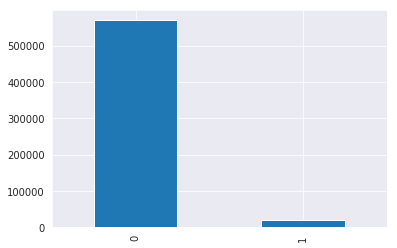

In [6]:
display(train.head())
display(test.head())
display(train['isFraud'].value_counts())
train['isFraud'].value_counts().plot.bar();

In [7]:
'''
fig , ax = plt.subplots(2,1, figsize = (16,10))
train['TransactionDay'] = train['TransactionDT'] // (24*3600)
train.groupby('TransactionDay')['isFraud'].sum().plot.line(ax=ax[0])
train.groupby('TransactionDay')['isFraud'].mean().plot.line(ax=ax[1])
'''

"\nfig , ax = plt.subplots(2,1, figsize = (16,10))\ntrain['TransactionDay'] = train['TransactionDT'] // (24*3600)\ntrain.groupby('TransactionDay')['isFraud'].sum().plot.line(ax=ax[0])\ntrain.groupby('TransactionDay')['isFraud'].mean().plot.line(ax=ax[1])\n"

**Transforming Datatime (in milliseconds) to Date, Day, Month, Hour and Weekday** 

In [8]:
# Assuming Dec 2017 as the start date for the data
'''
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['Date'] = train['TransactionDT'].apply(lambda x: startdate+datetime.timedelta(seconds=x))
train['Month/Year'] = train['Date'].dt.month.astype(str)+'/'+train['Date'].dt.year.astype(str)
train['Weekday'] = train['Date'].dt.dayofweek
train['Hour'] = train['Date'].dt.hour
train['Day'] = train['Date'].dt.day
'''

"\nstartdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')\ntrain['Date'] = train['TransactionDT'].apply(lambda x: startdate+datetime.timedelta(seconds=x))\ntrain['Month/Year'] = train['Date'].dt.month.astype(str)+'/'+train['Date'].dt.year.astype(str)\ntrain['Weekday'] = train['Date'].dt.dayofweek\ntrain['Hour'] = train['Date'].dt.hour\ntrain['Day'] = train['Date'].dt.day\n"

In [9]:
'''
fig, ax = plt.subplots(4, 1, figsize = (16,24))
#train.groupby('Date')['isFraud'].mean().plot.line(ax = ax[0])
train.groupby('Month/Year')['isFraud'].mean().plot.line(ax = ax[0],ylim=(0,0.05))
train.groupby('Weekday')['isFraud'].mean().plot.line(ax = ax[1],ylim=(0,0.04))
train.groupby('Day')['isFraud'].mean().plot.line(ax = ax[2],ylim=(0,0.05))
train.groupby('Hour')['isFraud'].mean().plot.line(ax = ax[3],ylim=(0,0.12))
'''

"\nfig, ax = plt.subplots(4, 1, figsize = (16,24))\n#train.groupby('Date')['isFraud'].mean().plot.line(ax = ax[0])\ntrain.groupby('Month/Year')['isFraud'].mean().plot.line(ax = ax[0],ylim=(0,0.05))\ntrain.groupby('Weekday')['isFraud'].mean().plot.line(ax = ax[1],ylim=(0,0.04))\ntrain.groupby('Day')['isFraud'].mean().plot.line(ax = ax[2],ylim=(0,0.05))\ntrain.groupby('Hour')['isFraud'].mean().plot.line(ax = ax[3],ylim=(0,0.12))\n"

In [10]:
data = train.append(test, sort = False)

In [11]:
data['NullCount'] = data.isnull().sum(axis=1).astype('int16')

In [12]:
vcols = [f'V{i}' for i in range(1,340)]
scaler = MinMaxScaler()
pca = PCA(n_components = 2)

vcol_pca = pca.fit_transform(scaler.fit_transform(data[vcols].fillna(-1)))

data['vcol_pca0'] = vcol_pca[:, 0]
data['vcol_pca1'] = vcol_pca[:, 1]
data['vcol_nulls'] = data[vcols].isnull().sum(axis = 1).astype('int16')

In [13]:
data.drop(vcols, axis = 1, inplace = True)

In [14]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
data['Date'] = data['TransactionDT'].apply(lambda x: startdate+datetime.timedelta(seconds=x))
data['Month/Year'] = data['Date'].dt.month.astype(str)+'/'+data['Date'].dt.year.astype(str)
data['Weekday'] = data['Date'].dt.dayofweek.astype('int8')
data['Hour'] = data['Date'].dt.hour.astype('int8')
data['Day'] = data['Date'].dt.day.astype('int8')
data.drop('Date', axis = 1, inplace = True)

In [15]:
cat_columns = [f'id_{i}' for i in range(12, 39)]
cat_columns += ['ProductCD','card1','card2','card3','card4','card5','card6','addr1',
                    'addr2','P_emaildomain','R_emaildomain','M1','M2','M3','M4','M5',
                    'M6','M7','M8','M9','DeviceType','DeviceInfo']
#print(cat_columns)
for col in cat_columns:
    data[col].fillna('Unknown', inplace = True)

In [16]:
encoded_columns = []
for col, typ in data.loc[:, data.columns != 'isFraud'].dtypes.iteritems():
    if typ == object:
        encoded_columns.append(col)
        data[col] = pd.factorize(data[col])[0]
        
#print(encoded_columns)

In [17]:
X_train = data[data['isFraud'].notnull()]
X_test = data[data['isFraud'].isnull()].drop('isFraud', axis = 1)
y_train = X_train.pop('isFraud')

In [18]:
del data

In [19]:
X_train = X_train.drop('TransactionID', axis = 1)


In [20]:
X_test_id = X_test.pop('TransactionID')

In [21]:
X_test_id

0         3663549
1         3663550
2         3663551
3         3663552
4         3663553
           ...   
506686    4170235
506687    4170236
506688    4170237
506689    4170238
506690    4170239
Name: TransactionID, Length: 506691, dtype: int32

In [22]:
%%time

params = {'learning_rate' : 0.01,
          'objective' : 'binary',
          'metric' : 'auc',
          'num_threads' : -1,
          'num_leaves' : 256,
          'verbose' : 1,
          'random_state' : 42,
          'bagging_fraction' : 1,
          'feature_fraction' : 0.85}

train_pred = np.zeros(X_train.shape[0])
test_pred = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators = 3000)
clf.fit(X_train, y_train)

train_preds = clf.predict_proba(X_train, num_iteration = clf.best_iteration_)[: , 1]
test_preds = clf.predict_proba(X_test, num_iteration = clf.best_iteration_)[: , 1]


CPU times: user 1h 9min 56s, sys: 47.1 s, total: 1h 10min 43s
Wall time: 18min 6s


AUC:  0.9999870633347369


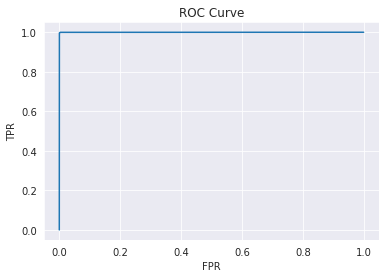

In [23]:
fpr, tpr, _ = roc_curve(y_train, train_preds)
auc = roc_auc_score(y_train, train_preds)

plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
#area_under_curve
print("AUC: ", auc)

In [24]:
submission = pd.DataFrame()
submission['TransactionID'] = X_test_id
submission['isFraud'] = test_preds
submission.to_csv('submission.csv', index = False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 